## Part 1. Dataset preparation

In training our model, we will use a dataset for self-driving cars.

Step 1.

Let's start by looking at our dataset. Inside are a bunch of similarly named folders, each of which contains pictures. But we can distinguish two types of pictures in this dataset.
1) These are ordinary color pictures. For example dataA/dataA/CameraRGB/02_00_000.png
2) And there are pictures associated with them, divided into areas with the same pixel brightness.
For example dataA/dataA/CameraSeg/02_00_000.png, everything in it is the same as in the first one, but it is segmented.

And we also note that nowhere in the dataset there is explicit information about the classes. We must name them ourselves.



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's find unique pixel values ​​in the picture, and each such value will correspond to the whole class.

In [ ]:
! pip install -q kaggle  

from google.colab import files


files.upload() 

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

# DATA_ROOT = '/kaggle/input/lyft-udacity-challenge/'


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                              Data Science Job Salaries                        7KB  2022-06-15 08:59:12          21836        677  1.0              
josephcheng123456/olympic-historical-dataset-from-olympediaorg  Olympic Historical Dataset From Olympedia.org   25MB  2022-08-18 14:18:14            725         28  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts             McDonald's India : Menu Nutrition Dataset        5KB  2022-07-28 17:08:52           1929        101  0.941176

In [ ]:
!unzip /content/lyft-udacity-challenge.zip 
!mkdir dataset

Streaming output truncated to the last 5000 lines.
  inflating: datac/dataC/CameraSeg/02_00_004.png  
  inflating: datac/dataC/CameraSeg/02_00_005.png  
  inflating: datac/dataC/CameraSeg/02_00_014.png  
  inflating: datac/dataC/CameraSeg/02_00_015.png  
  inflating: datac/dataC/CameraSeg/02_00_024.png  
  inflating: datac/dataC/CameraSeg/02_00_025.png  
  inflating: datac/dataC/CameraSeg/02_00_034.png  
  inflating: datac/dataC/CameraSeg/02_00_035.png  
  inflating: datac/dataC/CameraSeg/02_00_044.png  
  inflating: datac/dataC/CameraSeg/02_00_045.png  
  inflating: datac/dataC/CameraSeg/02_00_054.png  
  inflating: datac/dataC/CameraSeg/02_00_055.png  
  inflating: datac/dataC/CameraSeg/02_00_064.png  
  inflating: datac/dataC/CameraSeg/02_00_065.png  
  inflating: datac/dataC/CameraSeg/02_00_074.png  
  inflating: datac/dataC/CameraSeg/02_00_075.png  
  inflating: datac/dataC/CameraSeg/02_00_084.png  
  inflating: datac/dataC/CameraSeg/02_00_085.png  
  inflating: datac/dataC/Camera

In [ ]:
DATA_ROOT = '/content/dataset/'

# !mv /content/dataA 
# import shutil
!mv /content/dataA /content/dataset
# !mv /content/dataB /content/dataset
# !mv /content/dataC /content/dataset
# !mv /content/dataD /content/dataset
# !mv /content/dataE /content/dataset
# !mv /content/dataa /content/dataset
# !mv /content/datab /content/dataset
# !mv /content/datac /content/dataset
# !mv /content/datad /content/dataset
# !mv /content/datae /content/dataset

# shutil.move('/content/lyft-udacity-challenge.zip','/content/dataset1')
# !unzip /content/dataset1/lyft-udacity-challenge.zip 

# shutil.move('/content/dataA','/content/dataset')
# shutil.move('/content/dataB','/content/dataset')
# shutil.move('/content/dataC','/content/dataset')
# shutil.move('/content/dataD','/content/dataset')
# shutil.move('/content/dataE','/content/dataset')

# shutil.move('/content/dataa','/content/dataset')
# shutil.move('/content/datab','/content/dataset')
# shutil.move('/content/datac','/content/dataset')
# shutil.move('/content/datad','/content/dataset')
# shutil.move('/content/datae','/content/dataset')

In [ ]:
# !mkdr /content/dataset/dataA/dataA 
# shutil.move('/content/dataset/dataA/CameraRGB', '/content/dataset/dataA/dataA')
# shutil.move('/content/dataset/dataA/CameraSeg','/content/dataset/dataA/dataA')

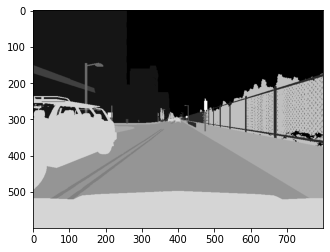

In [ ]:
img = plt.imread(DATA_ROOT + 'dataA/dataA/CameraSeg/02_00_000.png')
plt.imshow(img[..., 0], cmap='gray');

In [ ]:
np.unique(img * 255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

As a result, we see that we have 13 classes. You can display the semantic mask for each class yourself using the code below:

In [ ]:
labels = ['Unlabeled','Building','Fence','Other',
          'Pedestrian', 'Pole', 'Roadline', 'Road',
          'Sidewalk', 'Vegetation', 'Car','Wall',
          'Traffic sign']

[  0 255]


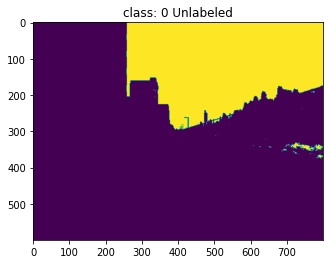

[  0 255]


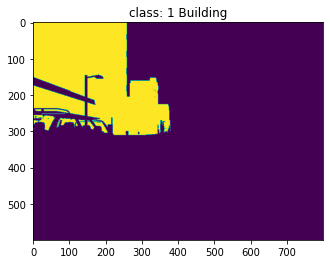

[  0 255]


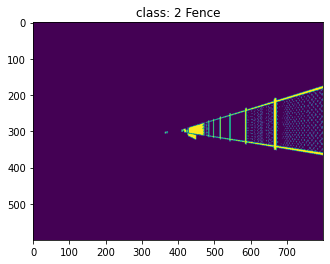

[  0 255]


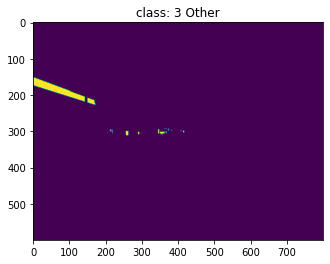

[0]


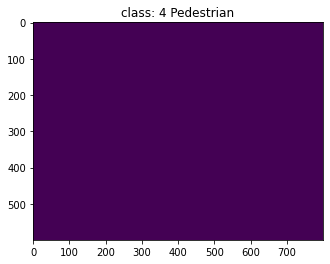

[  0 255]


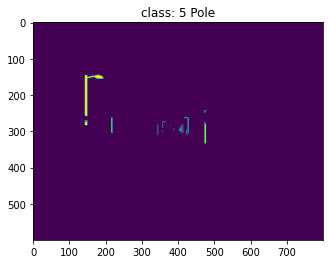

[  0 255]


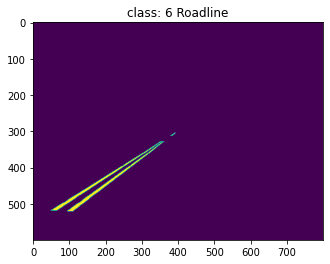

[  0 255]


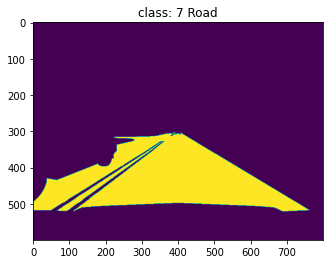

[  0 255]


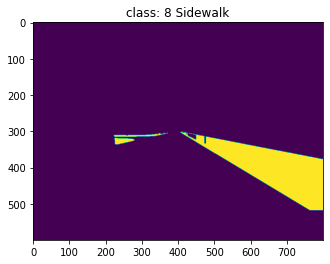

[  0 255]


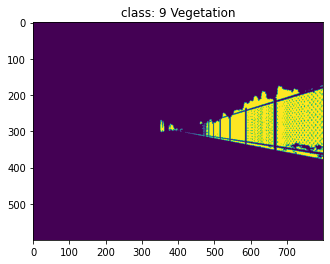

[  0 255]


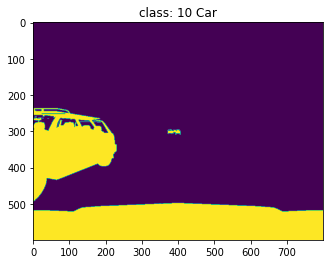

[  0 255]


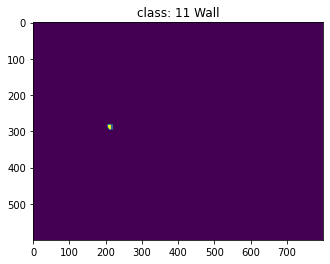

[  0 255]


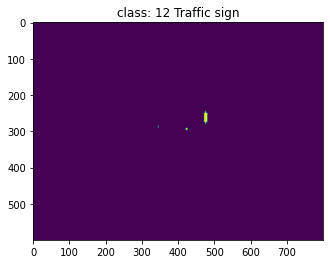

In [ ]:
for i in range(13):
    mask = plt.imread(DATA_ROOT+'dataA/dataA/CameraSeg/02_00_000.png') * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

Step 2

Now let's bring our dataset to a convenient form, for this we first divide everything into two lists with rgb pictures and seg.

In [ ]:
# DATA_ROOT = '/kaggle/input/lyft-udacity-challenge/'

In [ ]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

Now let's wrap these two lists in a DataFrame from the pandas library.
As a result, we will display the first five records from the resulting dataframe:



In [ ]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Sort the dataframe by values
df.sort_values(by='cameraRGB',inplace=True)

df.reset_index(drop=True, inplace=True)
# Let's display the first five values ​​of our dataframe
df.head(5)

,cameraRGB,cameraSeg
0,/content/dataset/dataA/dataA/CameraRGB/02_00_0...,/content/dataset/dataA/dataA/CameraSeg/02_00_0...
1,/content/dataset/dataA/dataA/CameraRGB/02_00_0...,/content/dataset/dataA/dataA/CameraSeg/02_00_0...
2,/content/dataset/dataA/dataA/CameraRGB/02_00_0...,/content/dataset/dataA/dataA/CameraSeg/02_00_0...
3,/content/dataset/dataA/dataA/CameraRGB/02_00_0...,/content/dataset/dataA/dataA/CameraSeg/02_00_0...
4,/content/dataset/dataA/dataA/CameraRGB/02_00_0...,/content/dataset/dataA/dataA/CameraSeg/02_00_0...


Step 3

Now let's wrap everything in a custom dataset for convenient work in PyTorch.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

Let's create a class for a custom dataset:



In [ ]:
class SelfDrivingDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # We serve our prepared dataframe
        self.data = data
        
        # Splitting the dataframe into rgb images
        self.image_arr = self.data.iloc[:,0]
        # and segmented pictures
        self.label_arr = self.data.iloc[:,1]
        
        # Number of picture-segmentation pairs
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # We read the picture and immediately present it as a numpy array 
        # size 600x800 float-values
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Normalize the image in values ​​[0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # counting a segmented image
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
#         mask = Image.open(self.label_arr[index])
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask)
        
        for i in range(13):
            cls_mask = np.where(mask == i, 255, 0)
            cls_mask = cls_mask.astype('float')
            cls_mask = cv2.resize(cls_mask, (256, 256))

            masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


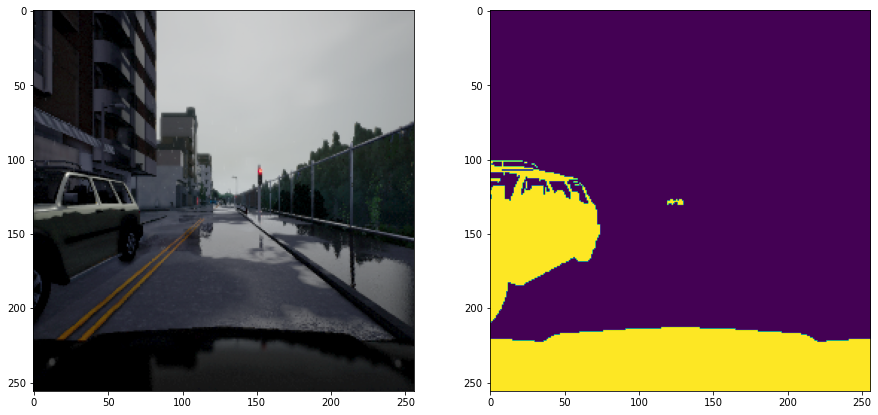

In [ ]:
dataset = SelfDrivingDataset(df)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

Then we divide our dataset into training and test sets.
And wrap them in our custom class.



In [ ]:
from sklearn.model_selection import train_test_split

# 70% to the training sample, 30% to the test sample
X_train, X_test = train_test_split(df, test_size=0.3)

# Ordering indexing
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# We wrap each sample in our custom dataset
train_data = SelfDrivingDataset(X_train)
test_data = SelfDrivingDataset(X_test)

And now let's wrap what happened in the dataloaders known to us in pytorch:


In [ ]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(0.) tensor(0.8471)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


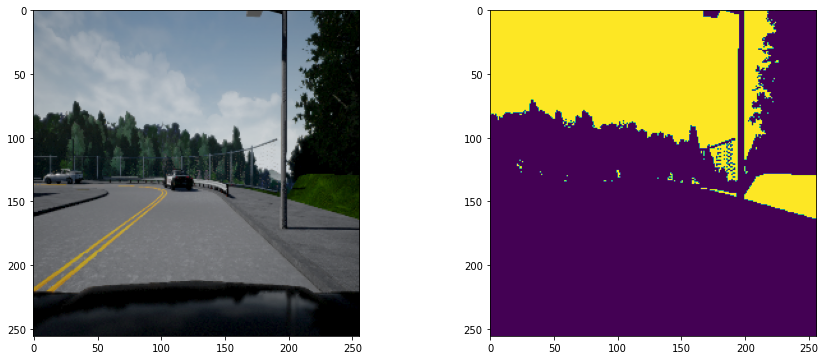

In [ ]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

## Part 2. Model creation

As we noted earlier, the architecture has a 3x3 double convolutional layer following the Relu activation function in both parts of the mesh.


Step 1.

Let's create a function conv_block(), whose parameters are the input and output parameters of the channels. Within the function, successive convolutional layers with a kernel of 3 (3x3) each precede the Relu activation function and for better convergence BatchNorm2d layers:

```
import torch
import torch.nn as nn

def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv
```

Step 2

Let's create the Unet() class and make the left side layers and the maxpool layers. In each layer we use conv_block(). Let's name the layers conv_down (4 layers on the left side):


```
class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()
        
        self.num_classes = num_classes
        self.down_conv_11 = conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = conv_block(in_channels=512, out_channels=1024)
```



Let's make a forward() function inside the class, with which we will send the input image to the left side:



```
        def forward(self, X):
        
            x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
            x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
            x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
            x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
            x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
            x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
            x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
            x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
            middle_out = self.middle(x8) # [-1, 1024, 16, 16]
```



Вот, отлично. Мы создали левую часть нейронной сети. Осталось сделать правую часть.

Step 4

Now let's declare the 4 layers of the right side and the last 1x1 conv in our class's __init__() function. Instead of the maxpool function, we will use a 2x2 transpose convolution which will increase our dimension:

```
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
```


Step 5

As we can see, in the architecture, the input image on the right side is a combination of the image on the left side
and from the previous layer. But for a combination of images, they must be the same size. So let's create a crop_tensor() function to crop these images. Inside this function, we imply that our images are tensors.

What happens in the crop_tensor() function?

tensor = left side image to be cropped
target tensor = the image on the right side that is mapped to the cropped left image

Let's take the last size of both tensors target_size and tensor_size, because their height and width are the same.
For example: x=torch.Size([1,512,64,64]), so x[2] = 64

Now, having the dimensions of both images, we subtract the size of the smaller tensor from the larger one. Suppose
target_size = 56 and tensor_size = 64 -> delta (difference between sizes) will be 8.

But we'll be cutting the image out of all the 'height' * 'width' corners, so we'll divide delta by 2.
So height and width can be cut equal to:
    8 => h*w=4*4

now return the cut tensor
[:,:,] = all dimensions
[delta:tensor_size-delta, delta:tensor_size-delta] = cutout image

[4:64-4, 4:64-4] => 4:60, 4:60
in the example above, we need a 56x56 image

The picture below shows an example of a cut height:

<img src='https://drive.google.com/uc?export=view&id=1AURG8EdTu1OHHj8nxSRhEsrGqc4WNb5V' width=500>

In [ ]:
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

Step 6

Now let's add our forward to the right side.


Combine both images using torch.cat() and substitute in up_conv():





```
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        
        return output
```



Now for the view, let's write our previously created functions inside the class. As a result, our Unet class looks like this:

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Left side (The way to reduce the dimension of the picture)

        self.down_conv_11 = self.conv_block(in_channels=3,
                                            out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64,
                                            out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128,
                                            out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256,
                                            out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Right side (The way to increase the dimension of the picture)

        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024,
                                          out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512,
                                          out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256,
                                          out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128,
                                          out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes,
                                kernel_size=3, stride=1,
                                padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Walk on the left side
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Walk on the right side
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

## Part 3. Training



*We* have data ready and a specific network that we want to train. It's time to build the basic training pipeline.

Determine the learning rate and the number of epochs:

In [ ]:
learning_rate = 0.001
epochs = 1

Let's choose a device on which we will train our model:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Let's define our Unet model for 13 classes:



In [ ]:
Umodel = UNet(num_classes=13).to(device)

In [ ]:
sample = (next(iter(train_data_loader)))
sample[1].shape

torch.Size([8, 13, 256, 256])

In [ ]:
out = Umodel(sample[0].to(device))
out.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([8, 13, 256, 256])

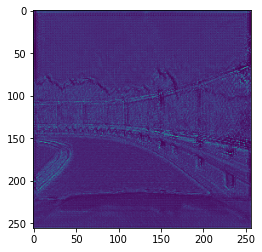

In [ ]:
plt.imshow(out[0][2].detach().cpu());

By training, we mean feeding the objective function to the optimizing function. Therefore, we choose an optimizing function and a loss function (objective function):



In [ ]:
optimizer = torch.optim.Adam(Umodel.parameters())

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

Let's determine the number of steps within one epoch:

In [ ]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 88 total_steps per epoch


In [ ]:
criterion = DiceLoss()

Let's start the learning process:



In [ ]:
#Import the time library to calculate how long it takes us to complete one epoch
import time


# run the main training loop
epoch_losses = []
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = data.to(device), labels.to(device)        
        
        optimizer.zero_grad()
        outputs = Umodel(data)                
        
        #loss = nn.CrossEntropyLoss(outputs,labels)# - torch.log(DiceLoss(outputs, labels))
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx % 10 == 0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')
        # if batch_idx ==50:
        #   break    

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    end_time = time.time()
    print(f'Spend time for 1 epoch: {end_time - start_time} sec')
    
    epoch_losses.append(epoch_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch index : 0 | loss : 0.9189039468765259
batch index : 10 | loss : 0.354059100151062
batch index : 20 | loss : 0.2904224395751953
batch index : 30 | loss : 0.3100883364677429
batch index : 40 | loss : 0.2347089648246765
batch index : 50 | loss : 0.2540844678878784
batch index : 60 | loss : 0.21167200803756714
batch index : 70 | loss : 0.19337457418441772
batch index : 80 | loss : 0.2146928310394287
Epoch 1, loss:  0.2794145088304173
Spend time for 1 epoch: 3597.3292841911316 sec


Let's save our model:

In [ ]:
save_model_path = './Unet_Model_dice_loss.pth'

In [ ]:
torch.save(Umodel.state_dict(), save_model_path)

In [ ]:
net = UNet(13).to(device)
net.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

In [ ]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


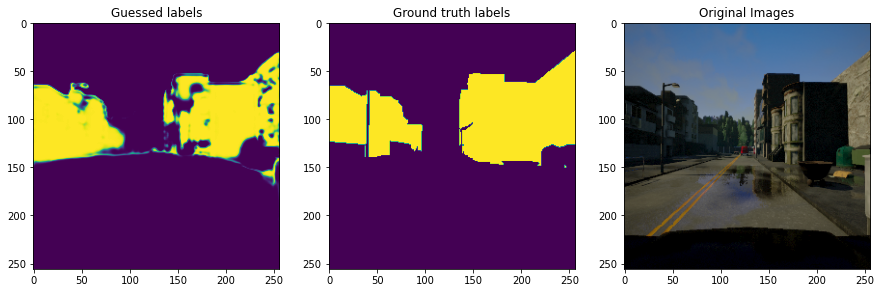

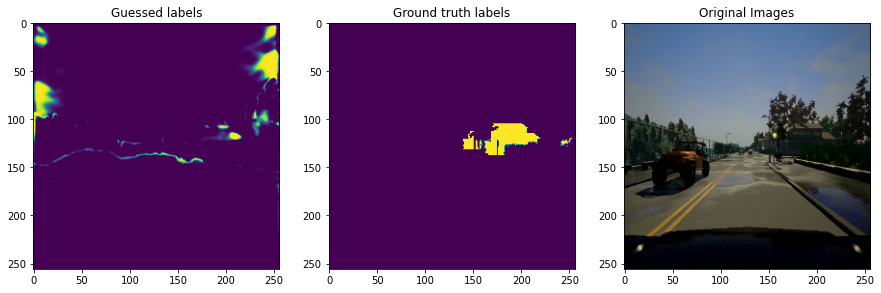

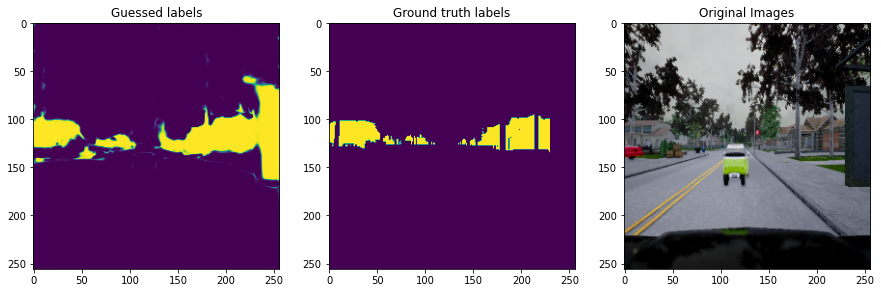

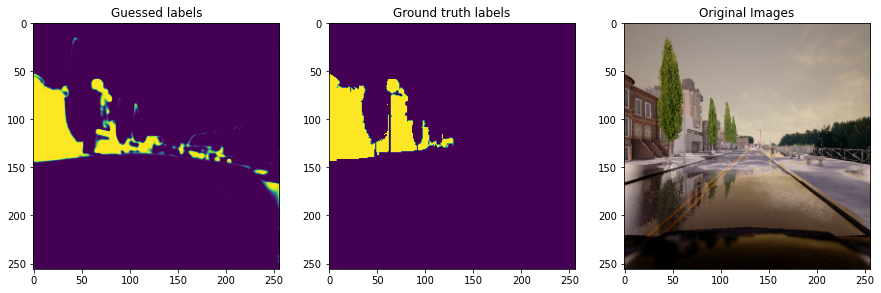

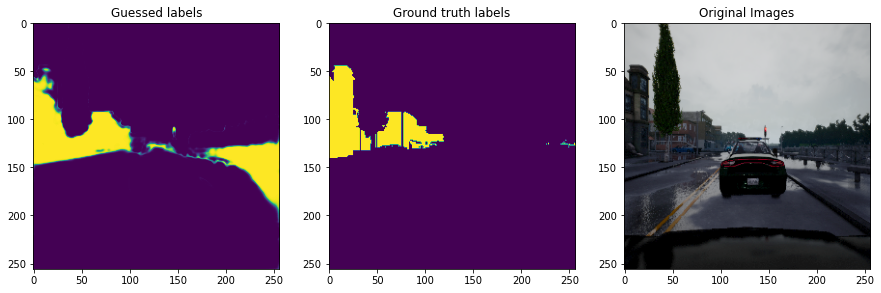

In [ ]:
class_idx = 1

for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,class_idx,:,:])
        axarr[0].set_title('Guessed labels')
        axarr[1].imshow(labels.detach().cpu().numpy()[j,class_idx, :,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break

In [ ]:
pip install segmentation-models-pytorch==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.4 MB/s 
     |████████████████████████████████| 376 kB 15.6 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=61f4d5b194b2a7e9c48b7dabf6c0a6ca15dc25ace86a7ede88dce2123c8f49d0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=33ad3e2fd5037f7df91d4f63386d06f85c678c850f8181fa847c3da34cdc5e98
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
activation = torch.nn.Softmax(dim=1)

In [ ]:
import segmentation_models_pytorch as smp

# model creation

BACKBONE = 'resnet34'
segmodel = smp.Unet(BACKBONE, classes=13, activation='softmax2d').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


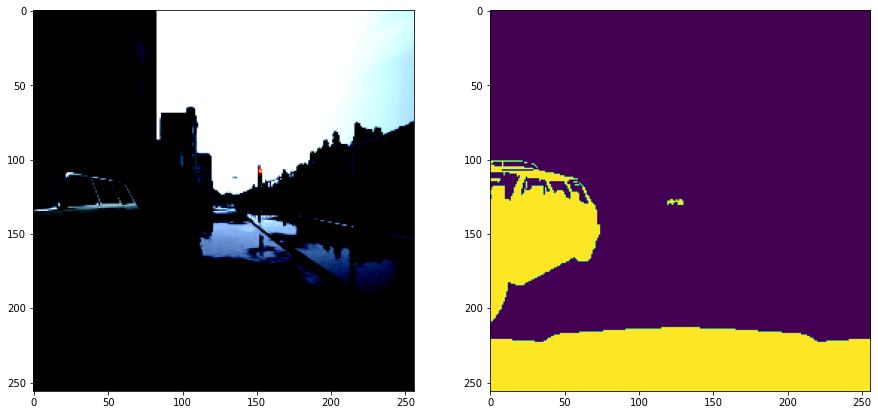

In [ ]:
dataset = SelfDrivingDataset(df, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

In [ ]:
# 70% to the training sample, 30% to the test sample


X_train, X_test = train_test_split(df, test_size=0.3)

# Ordering indexing
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# We wrap each sample in our custom dataset
train_data = SelfDrivingDataset(X_train,
                                preprocessing=preprocess_input)
test_data = SelfDrivingDataset(X_test,
                               preprocessing=preprocess_input)

In [ ]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [ ]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(-2.1179) tensor(1.9064)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


In [ ]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [ ]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 75/75 [01:48<00:00,  1.44s/it, dice_loss - 0.1779, iou_score - 0.7323]
Model saved!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


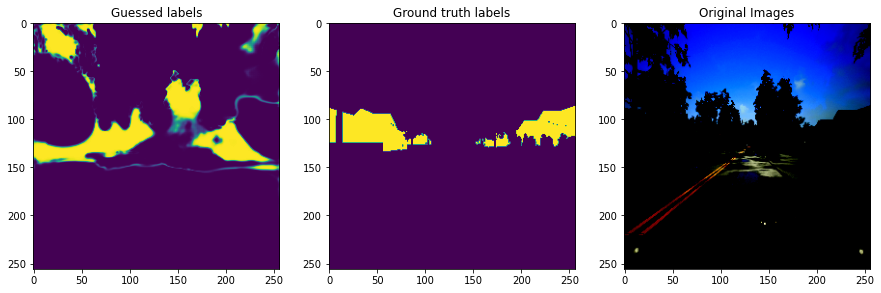

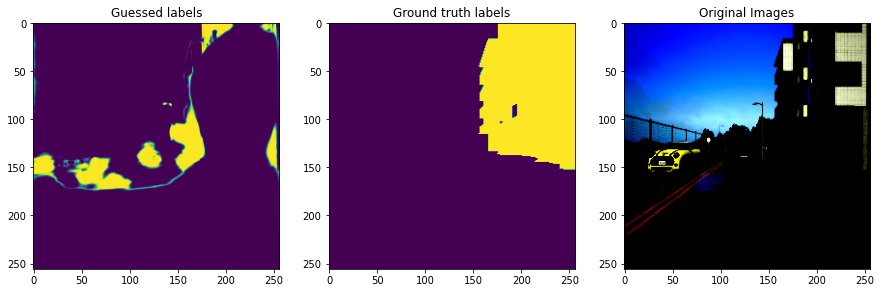

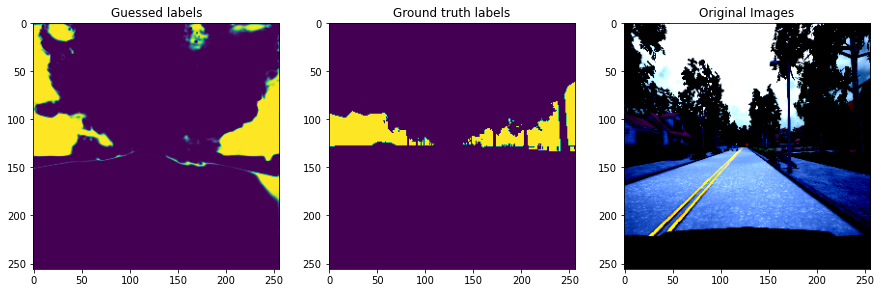

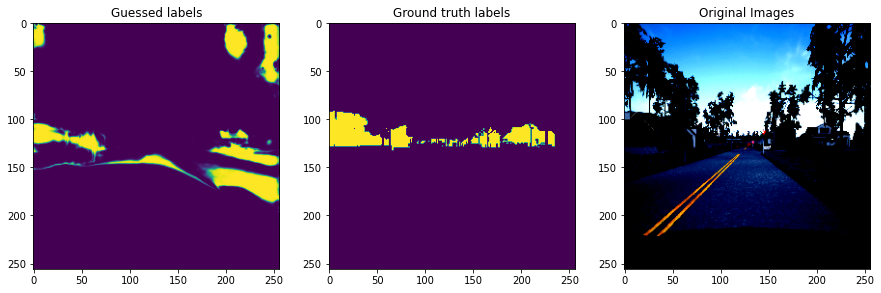

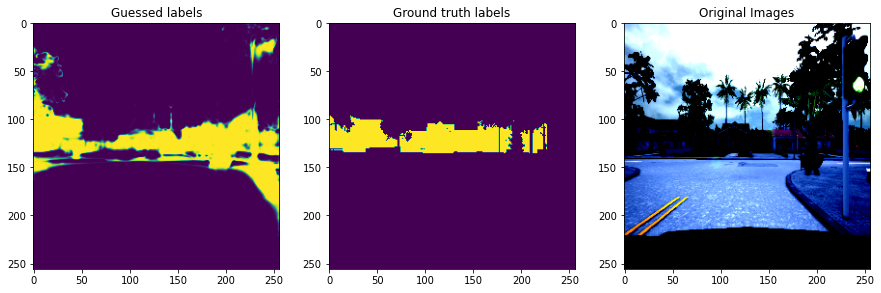

In [ ]:
class_idx = 1

for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,class_idx,:,:])
        axarr[0].set_title('Guessed labels')
        axarr[1].imshow(labels.detach().cpu().numpy()[j,class_idx, :,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break